In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

2024-02-18 20:01:39.320006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 20:01:39.320045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 20:01:39.321168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 20:01:39.327730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 20:01:40.029909: W tensorflow/comp

In [2]:
from image_processing import prep_dataset, thresholding

In [3]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Active GPU devices:")
    for gpu in gpus:
        print("  -", gpu.name)
else:
    print("No GPU devices found.")

TensorFlow version: 2.15.0
Active GPU devices:
  - /physical_device:GPU:0
  - /physical_device:GPU:1


In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [5]:
reconstructed_model = tf.keras.models.load_model("inpainting_v2", custom_objects = {"dice_coef": dice_coef})


2024-02-18 20:01:43.487657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21441 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-02-18 20:01:43.488342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22457 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [6]:
img_paths, mask_paths = prep_dataset.load_img_paths("../data/inpainting/AugmentedData")
imgs, masks = prep_dataset.read_paths_and_threshold(img_paths, mask_paths, 2, 2)
train_x, val_x, train_y, val_y = prep_dataset.setup_datasets(imgs, masks, norm_type='01')
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size=0.5, random_state=0)
train_x.shape, val_x.shape, test_x.shape

Function 'read_paths_and_threshold' executed in 3.2836s
Function 'setup_datasets' executed in 0.3434s


((800, 256, 256, 1), (100, 256, 256, 1), (100, 256, 256, 1))

In [7]:
test_preds = reconstructed_model.predict( test_x )

2024-02-18 20:01:49.757012: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-18 20:01:49.838247: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/4 [======>.......................] - ETA: 6s

2024-02-18 20:01:51.801959: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4/4 [==============================] - 3s 213ms/step


In [8]:
rows=10

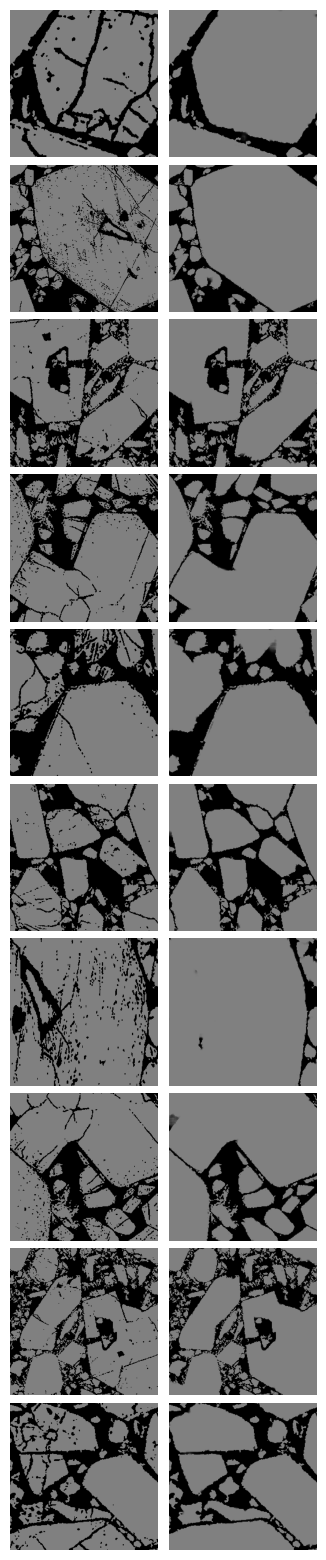

In [9]:
fig = plt.figure(figsize=(4, 2*rows))
gs = GridSpec(nrows=rows, ncols=2, figure=fig, hspace=0.05, wspace=0.05)

for i in range(rows):
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
   
    ax1.imshow(test_x[i], cmap='gray', vmin=0, vmax=1)
    ax2.imshow(test_preds[i], cmap='gray', vmin=0, vmax=1)
    
    ax1.set_axis_off()
    ax2.set_axis_off()

# plt.savefig("inpainting_v2_results.png")
plt.show()

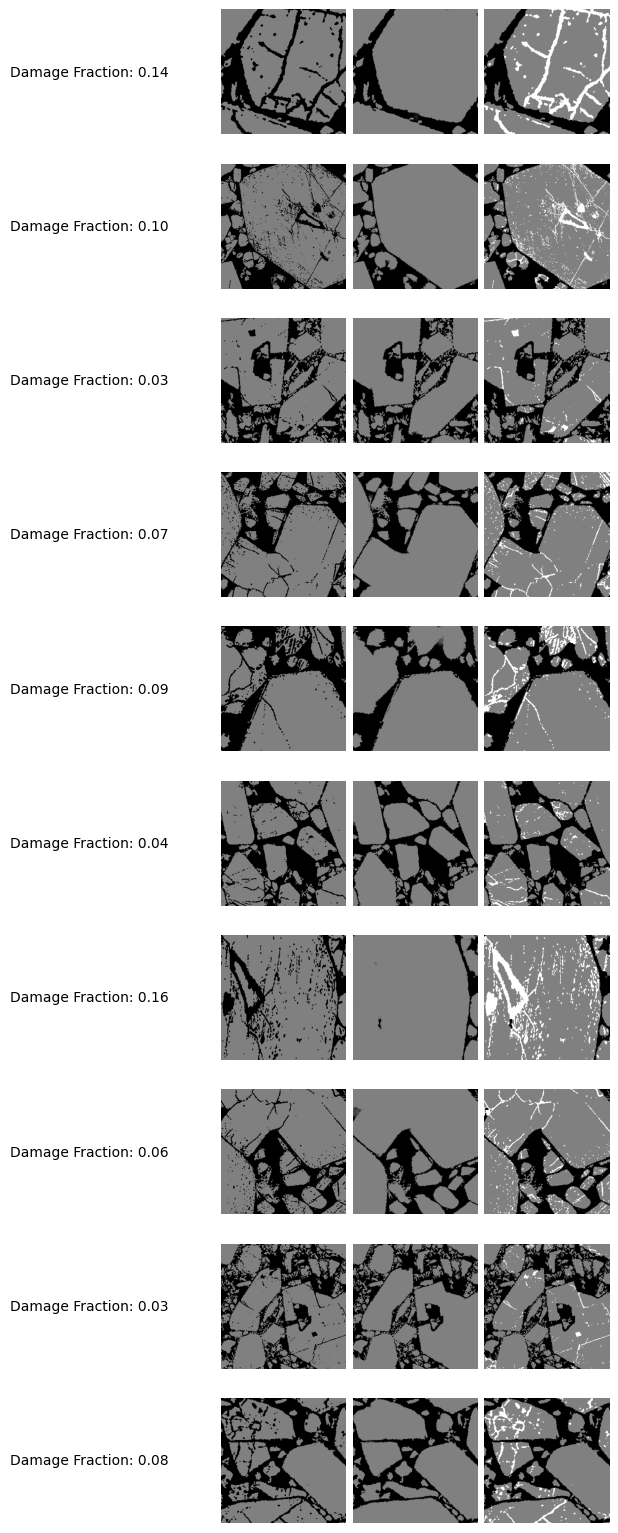

In [24]:
fig = plt.figure(figsize=(5, 2*rows))
gs = GridSpec(nrows=rows, ncols=3, figure=fig, hspace=0.02, wspace=0.05)

for i in range(rows): 
    img2 = prep_dataset.denormalize_0_1_to_0_255_uint8(test_x[i])
    img1 = thresholding.segment_two_phase(prep_dataset.denormalize_0_1_to_0_255_uint8(test_preds[i]))
    diffs, diff_img = thresholding.create_diff_image(img1, img2)

    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
    ax3 = fig.add_subplot(gs[i, 2])

    damage_fraction = thresholding.compute_damage_fraction(diff_img)

    ax1.imshow(test_x[i], cmap='gray', vmin=0, vmax=1)
    ax2.imshow(test_preds[i], cmap='gray', vmin=0, vmax=1)
    ax3.imshow(diff_img, cmap='gray', vmin=0, vmax=255)
  
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()

    row_text = f'Damage Fraction: {damage_fraction:.2f}'
    fig.text(0.02, ax1.get_position().y0 + ax1.get_position().height/2, row_text, va='center', ha='right', fontsize=10, transform=fig.transFigure)

plt.show()